In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nilearn.plotting import plot_design_matrix

sys.path.append(
    '/Users/jeanettemumford/Dropbox/Research/Projects/patrick/efficiency_rdoc'
)

%load_ext autoreload
%autoreload 2
from utils import (
    calc_avg_prob_next_given_last1_and_last2,
    calc_expected_run_num_by_chance,
    est_eff_and_vif,
    run_eff_sim,
    sample_shifted_truncated_exponential,
)

In [2]:
def make_stop_flank_stroop_gng_timings(
    nc1,
    nc2,
    c1_dur,
    c2_dur,
    blank_dur,
    nbreaks,
    break_fix_pre_message_dur,
    break_message_dur,
    break_fix_post_message_dur,
    isi_exp_lam,
    isi_truncation,
    isi_shift,
):
    """
    Produces a randomly ordered set of trials for the stop signal task, flanker, strop and go/nogo.
    Assumes a break between blocks of task.  Number of stop/go trials will be equal
    for each block of the task (nc1/(nbreaks + 1))
    ISI is sampled from a truncated exponential.  Note the truncation value for the
    truncated exponential does *not* include the shift, so the max isi is
    isi_truncation + isi_shift.
    A trial is structured as:
      fixation (based on truncated exponential) +
      either a stop/go trial (duration = c1_dur/c2_dur) +
      blank screen (duration = blank_dur) +
      next trial (same structure as above until end of block is reached)
      At end of block the break begins with:
      fixation (length=break_dur) +
      break message (break_message_dur) +
      post message fixation (post_message_dur)
    Input:
      nc1: Total number of condition 1 (will be evenly split between blocks)
             Integer divisible by (nbreaks + 1)
      nc2: Total number of condition 2 (will be evenly split between blocks)
           Integer divisible by (nbreaks + 1)
      c1_dur: Duration of a stop trial
      c2_dur: Duration of a go trial
      blank_dur:  Duration of blank screen after stop/go stimulus offset
      nbreaks: Total number of breaks (blocks = nbreaks + 1)
      break_fix_pre_message_dur: Fixation duration at beginning of break (no jittering)
      break_message_dur:  Duration of message shown during break
      break_fix_post_message_dur:  Fixation duration after message (no jittering)
      isi_exp_lam:  (seconds) The lambda parameter of the exponential used for the isi
                    (inverse is the non-truncated/non-shifted mean)
      isi_truncation: (seconds) Truncation value of the exponential *NOT* including shift.
                      Max ISI = isi_truncation + isi_shift
      isi_shift: (seconds) Shift value for isi (minimum isi value)
    Output:
       Events pandas data frame with onsets, trial_type and duration.
       Includes stop/go/break message timings
    """
    nblocks = nbreaks + 1
    ntrials = nc1 + nc2
    ntrials_per_block = int(ntrials / nblocks)
    nc1_per_block = int(nc1 / (nblocks))
    nc2_per_block = int(nc2 / (nblocks))
    isi_vals, _ = sample_shifted_truncated_exponential(
        isi_exp_lam, isi_truncation, isi_shift, ntrials
    )

    # fragments = all sub-components of the run (go/stop/fixation/blank/break_message)
    # Each stimulus has 3 fragments and each break has 3 fragments
    isi_count = 0
    fragment_durations = []
    fragment_labels = []
    for cur_block in range(nblocks):
        stim_type_block = np.random.permutation(
            np.concatenate(
                (
                    np.repeat(['cond1'], nc1_per_block),
                    np.repeat(['cond2'], nc2_per_block),
                )
            )
        )
        for cur_trial in range(ntrials_per_block):
            cur_stim_type = stim_type_block[cur_trial]
            stim_dur_cur_trial = c1_dur if cur_stim_type == 'cond1' else c2_dur
            fragment_durations.extend(
                [isi_vals[isi_count], stim_dur_cur_trial, blank_dur]
            )
            fragment_labels.extend(['isi_fix', cur_stim_type, 'blank'])
            isi_count = isi_count + 1
        # Add break
        fragment_durations.extend(
            [break_fix_pre_message_dur, break_message_dur, break_fix_post_message_dur]
        )
        fragment_labels.extend(['fix_break', 'break_message', 'fix_break'])

    # If you don't want the beginning of the run to start at 0, change this
    # (e.g. if you want to add the 10s to reach steady state)
    run_start = 0
    fragment_onsets = np.cumsum([run_start] + fragment_durations)[:-1]
    events_data = pd.DataFrame(
        {
            'onset': fragment_onsets,
            'trial_type': fragment_labels,
            'duration': fragment_durations,
        }
    )
    events_data = events_data.loc[
        events_data['trial_type'].str.contains('cond1|cond2|break_message') == True
    ]
    return events_data

## Stop Signal

In [3]:
events_inputs = {
    'nc1': 60,
    'nc2': 120,
    'c1_dur': 1,
    'c2_dur': 1,
    'blank_dur': 0.5,
    'nbreaks': 2,
    'break_fix_pre_message_dur': 6,
    'break_message_dur': 4,
    'break_fix_post_message_dur': 6,
    'isi_exp_lam': 2,
    'isi_truncation': 4.5,
    'isi_shift': 0.5,
}


tr = 1.49
total_time = 10 * 60
contrasts = {
    'stop': 'cond1',
    'go': 'cond2',
    'stop-go': 'cond1 - cond2',
    'task': '.5*cond1+.5*cond2',
}

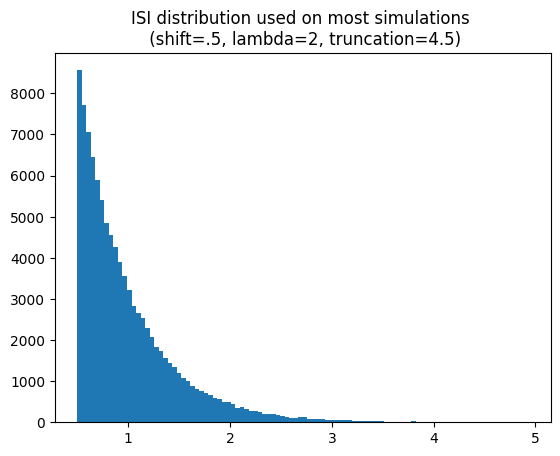

theoretical mean
0.9994445873382422
quartiles
[0.5   0.644 0.85  1.194 4.93 ]


In [4]:
nsamp = 100000
samples, theoretical_mean = sample_shifted_truncated_exponential(
    events_inputs['isi_exp_lam'],
    events_inputs['isi_truncation'],
    events_inputs['isi_shift'],
    nsamp,
)
isi_quartiles = np.round(np.quantile(samples, [0, 0.25, 0.5, 0.75, 1]), 3)

plt.hist(samples, 100)
plt.title(
    'ISI distribution used on most simulations \n (shift=.5, lambda=2, truncation=4.5)'
)
plt.show()
print('theoretical mean')
print(theoretical_mean)
print('quartiles')
print(isi_quartiles)

In [5]:
trials_psych_assess_map = {'cond1': '1', 'cond2': '2'}

unpermuted_trials = np.concatenate(
    [
        np.repeat('1', events_inputs['nc1'] / 3),
        np.repeat('2', events_inputs['nc2'] / 3),
    ],
    axis=0,
)
avg_trial_repeats_info = calc_expected_run_num_by_chance(unpermuted_trials, nsims=5000)

for val in ['1', '2']:
    avg_trial_repeats_info[f'{val}_run_counts'] = (
        avg_trial_repeats_info[f'{val}_run_counts'] * 3
    )
print(avg_trial_repeats_info.loc[:25, :])

# also get average conditional probabilities
avg_prob_given_last1, avg_prob_given_last2 = calc_avg_prob_next_given_last1_and_last2(
    unpermuted_trials
)

    run_length  1_run_counts  2_run_counts
0          1.0       27.0072       13.4592
1          2.0        9.0078        9.5406
2          3.0        2.8926        6.3978
3          4.0        0.9060        4.2558
4          5.0        0.2664        2.7294
5          6.0        0.0798        1.7988
6          7.0        0.0222        1.1280
7          8.0        0.0042        0.7476
8          9.0        0.0024        0.4536
9         10.0        0.0000        0.2844
10        11.0        0.0000        0.1620
11        12.0        0.0000        0.1146
12        13.0        0.0000        0.0624
13        14.0        0.0000        0.0390
14        15.0        0.0000        0.0210
15        16.0        0.0000        0.0120
16        17.0        0.0000        0.0072
17        18.0        0.0000        0.0054
18        19.0        0.0000        0.0018
19        20.0        0.0000        0.0000
20        21.0        0.0000        0.0024
21        22.0        0.0000        0.0012
22        2

In [6]:
print(avg_prob_given_last1)
print(avg_prob_given_last2)

  cond_val  pr(1|cond_val)  pr(2|cond_val)
0        1        0.323689        0.676311
1        2        0.338146        0.661854
  cond_pairs  pr(1|cond_pairs)  pr(2|cond_pairs)
0         11          0.288267          0.709433
1         12          0.321183          0.678817
2         21          0.340263          0.659737
3         22          0.346746          0.653254


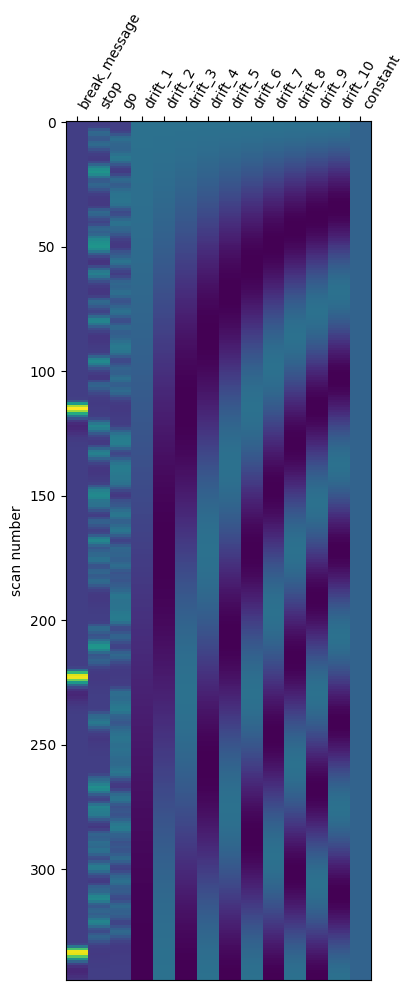

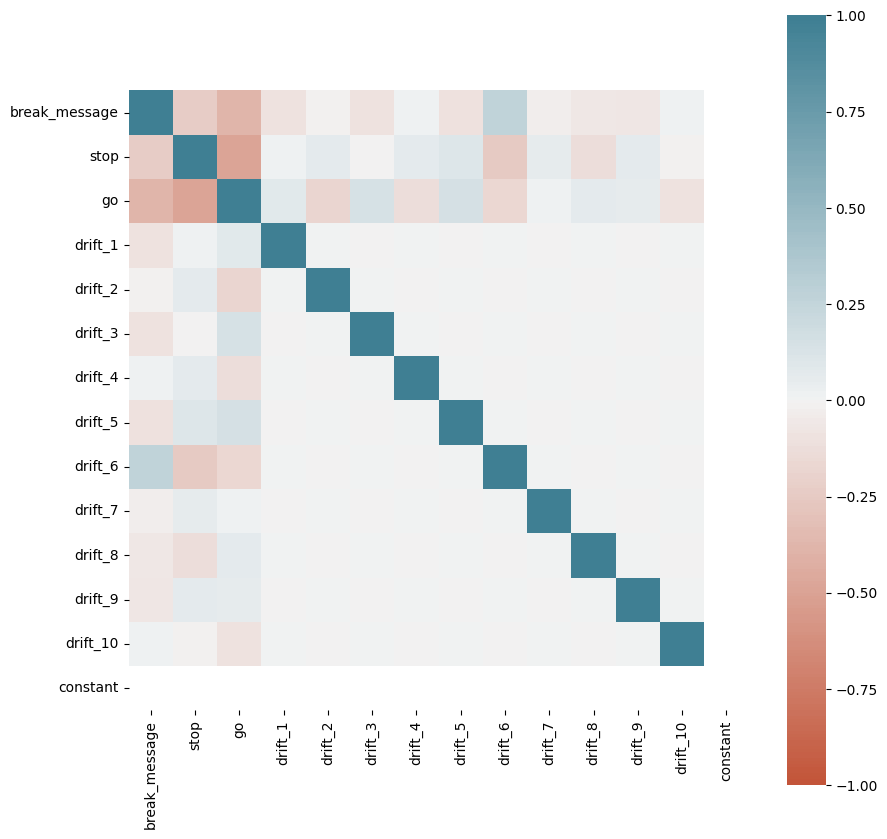

In [7]:
events_ts = make_stop_flank_stroop_gng_timings(**events_inputs)
_, _, desmat = est_eff_and_vif(
    events_ts, tr, total_time, contrasts, time_past_last_offset=20, deriv=False
)

name_swap = {'cond1': 'stop', 'cond2': 'go'}

desmat.columns = desmat.columns.to_series().replace(name_swap, regex=True)

plot_design_matrix(desmat)
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    desmat.corr(),
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax,
)
plt.show()

In [8]:
nsim = 250

output_setting1, events_setting1 = run_eff_sim(
    nsim,
    events_inputs,
    make_stop_flank_stroop_gng_timings,
    contrasts,
    avg_trial_repeats_info,
    tr,
    total_time,
    trials_psych_assess_map,
    avg_prob_given_last1,
    avg_prob_given_last2,
    name_swap=name_swap,
    time_past_last_offset=20,
    deriv=False,
)

In [9]:
output_setting1.columns

Index(['eff_stop', 'eff_go', 'eff_stop-go', 'eff_task', 'vif_stop', 'vif_go',
       'vif_stop-go', 'vif_task', 'scan_length', 'kao_measure',
       'prob_runs_gte_2', 'run_num_diff_from_avg', 'prob_next_given_last1',
       'prob_next_given_last2', 'sum_abs_diff_prob_next_given_last1',
       'sum_abs_diff_prob_next_given_last2'],
      dtype='object')

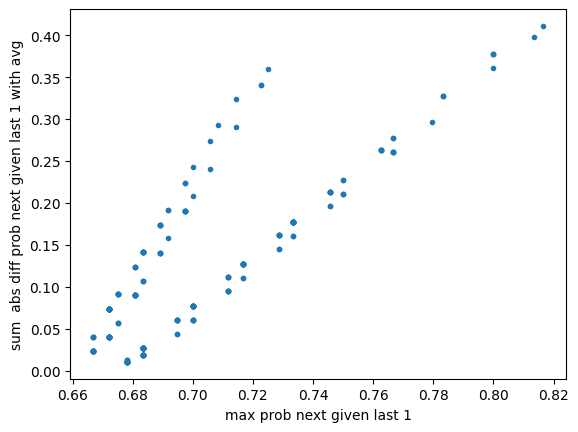

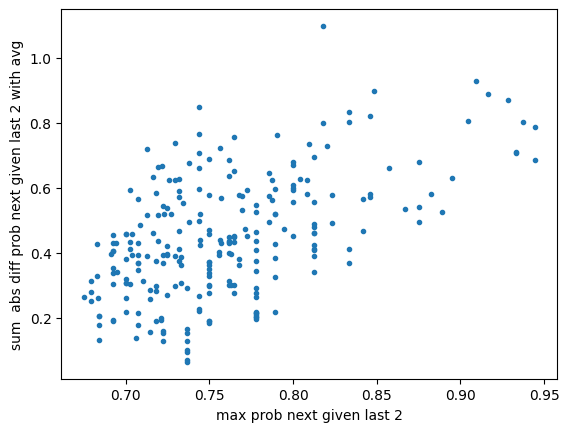

In [10]:
plt.plot(
    output_setting1['prob_next_given_last1'],
    output_setting1['sum_abs_diff_prob_next_given_last1'],
    '.',
)
plt.xlabel('max prob next given last 1')
plt.ylabel('sum  abs diff prob next given last 1 with avg')
plt.show()

plt.plot(
    output_setting1['prob_next_given_last2'],
    output_setting1['sum_abs_diff_prob_next_given_last2'],
    '.',
)
plt.xlabel('max prob next given last 2')
plt.ylabel('sum  abs diff prob next given last 2 with avg')
plt.show()

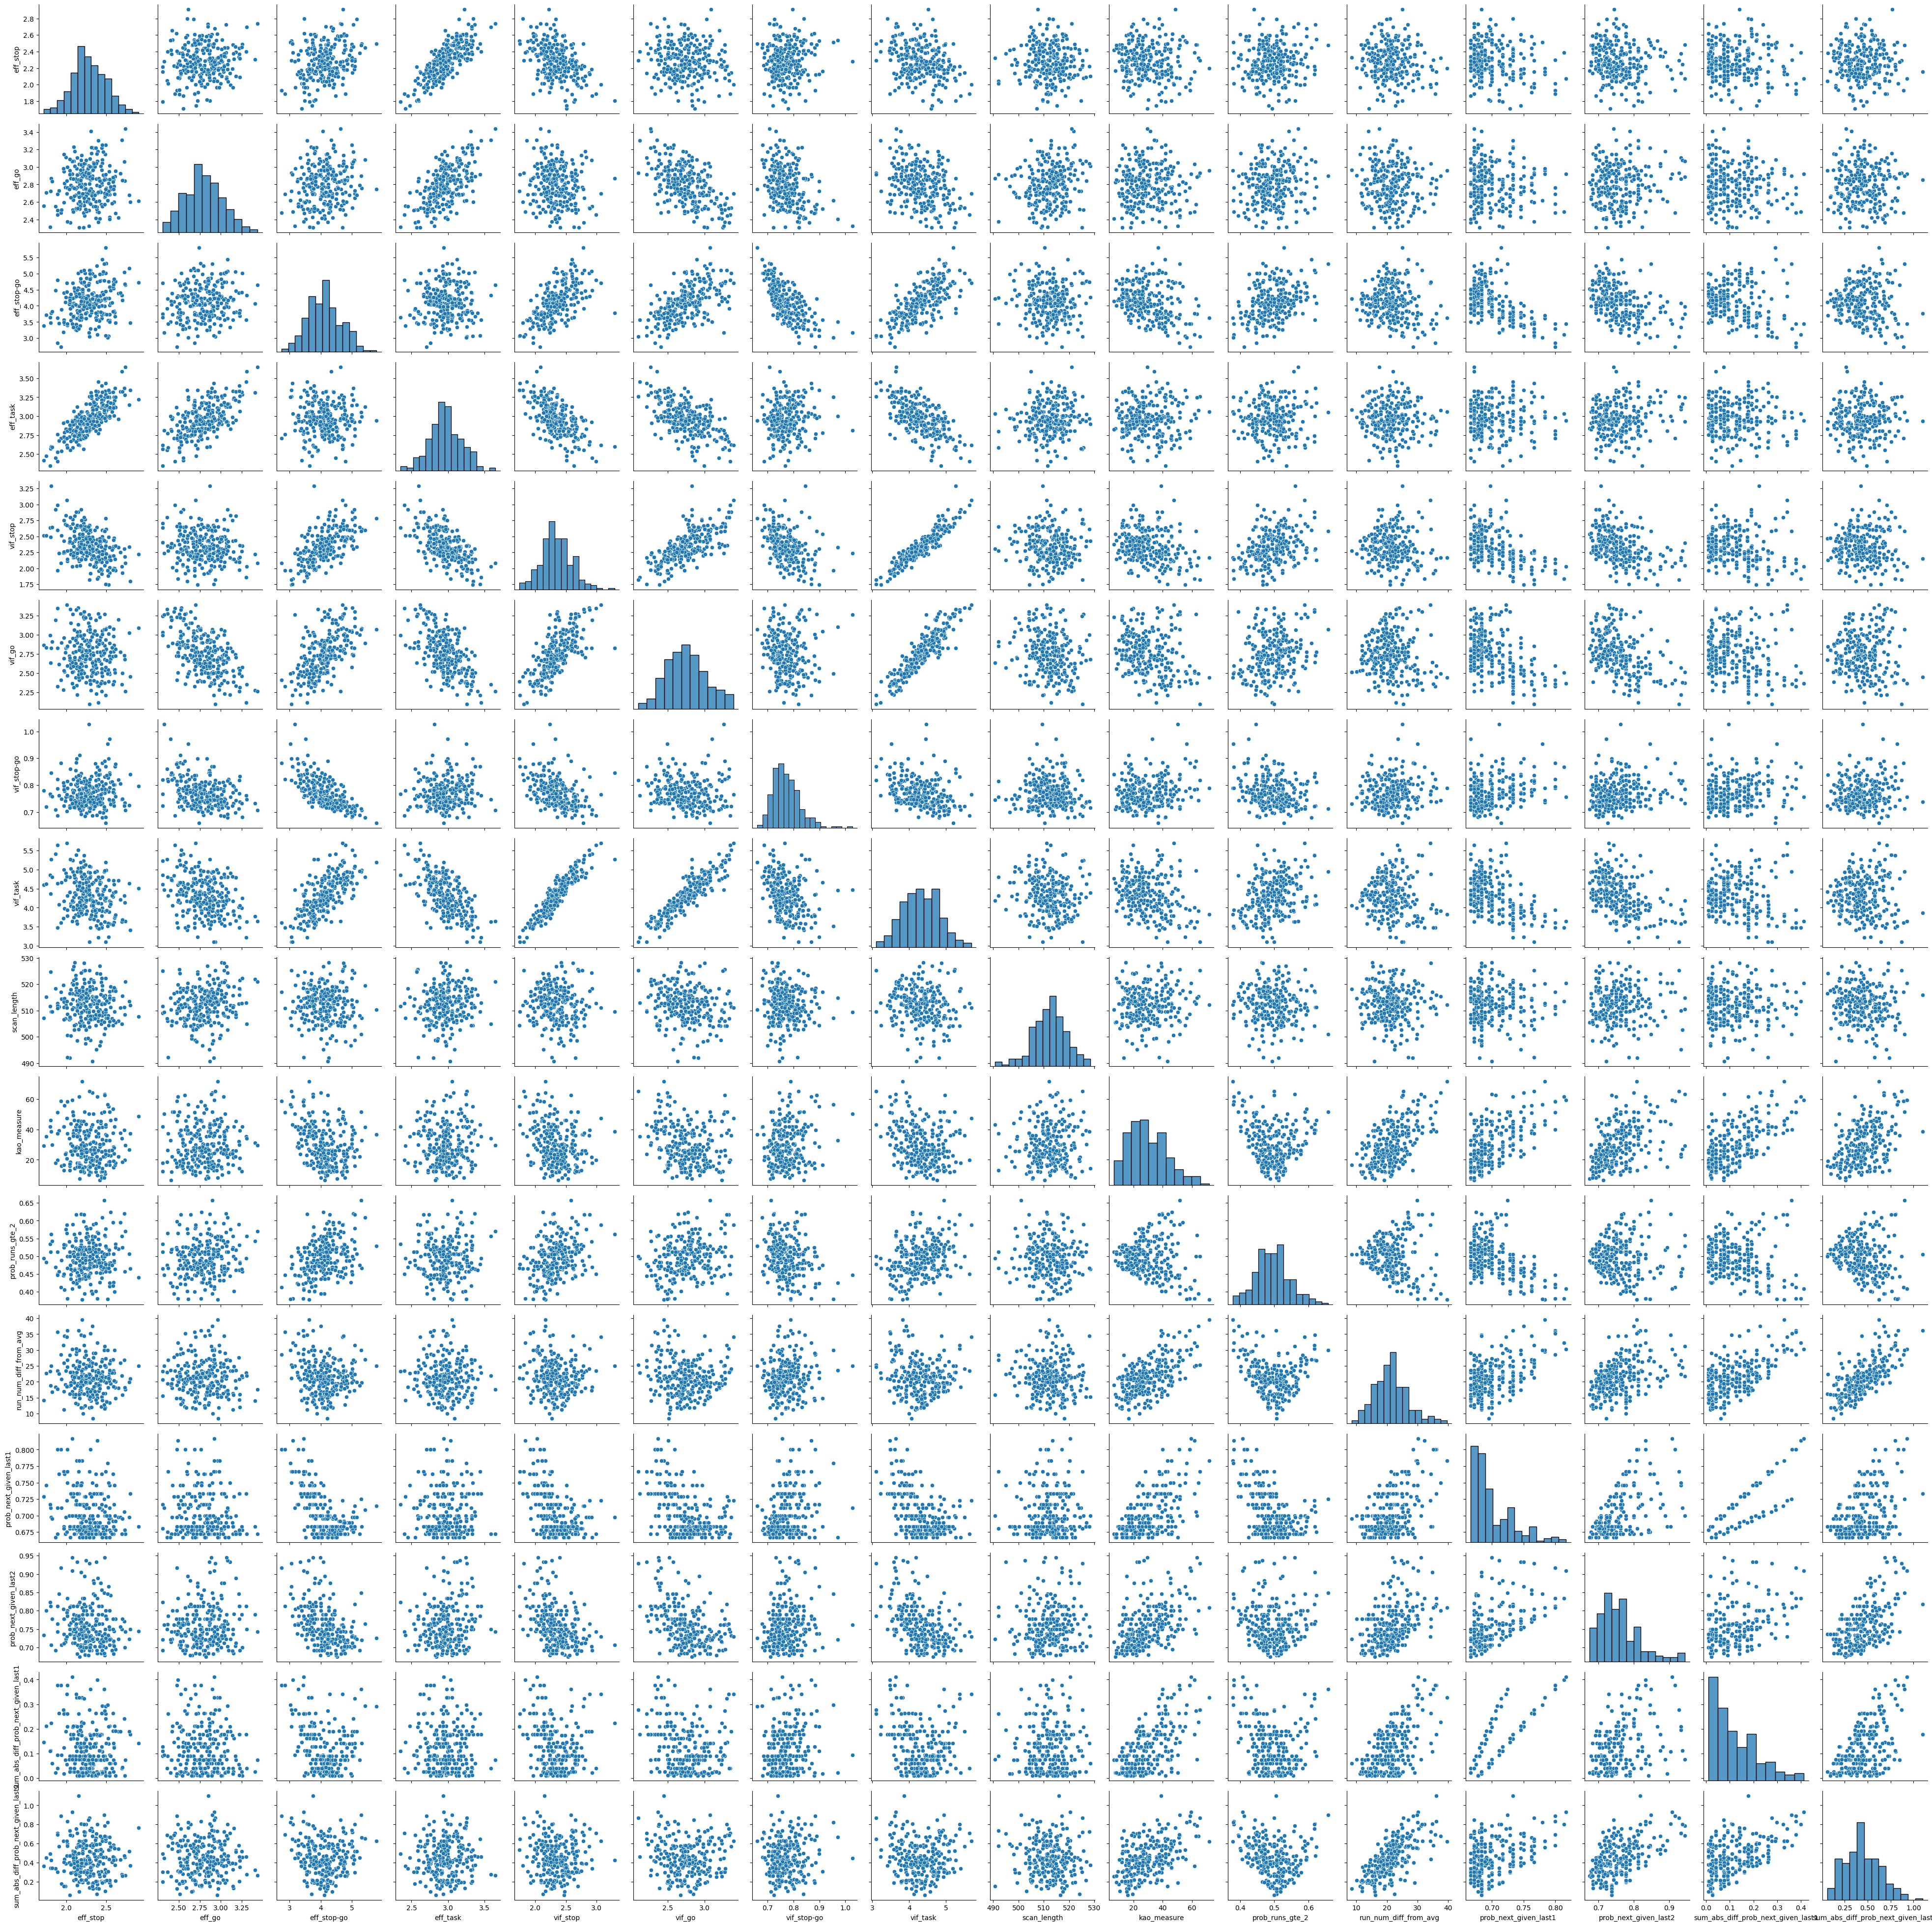

In [11]:
g = sns.PairGrid(output_setting1)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.savefig('/Users/jeanettemumford/Desktop/junk.pdf', format='pdf', bbox_inches='tight')

In [12]:
pd.set_option('display.width', 1000)

summary_names = (
    [f'eff_{name}' for name in contrasts.keys()]
    + [f'vif_{name}' for name in contrasts.keys()]
    + ['scan_length']
)

eff_vif_summaries = {}
eff_vif_summaries['setting1'] = np.round(
    output_setting1[summary_names].quantile(q=[0.05, 0.5, 0.95]), 2
)

for key, val in eff_vif_summaries.items():
    print(f'Results for {key}')
    print(val)

Results for setting1
      eff_stop  eff_go  eff_stop-go  eff_task  vif_stop  vif_go  vif_stop-go  vif_task  scan_length
0.05      1.95    2.45         3.29      2.59      1.97    2.34         0.70      3.54       500.81
0.50      2.27    2.79         4.11      2.95      2.32    2.73         0.77      4.31       512.53
0.95      2.61    3.17         5.01      3.32      2.77    3.24         0.87      5.11       522.93


### Stop signal, cut end fixation to 10s

In [13]:
nsim = 250
output_decrease_time_past_offset, events_decrease_fix = run_eff_sim(
    nsim,
    events_inputs,
    make_stop_flank_stroop_gng_timings,
    contrasts,
    avg_trial_repeats_info,
    tr,
    total_time,
    trials_psych_assess_map,
    avg_prob_given_last1,
    avg_prob_given_last2,
    name_swap=name_swap,
    time_past_last_offset=10,
    deriv=False,
)

In [14]:
eff_vif_summaries['decrease time past offset'] = np.round(
    output_decrease_time_past_offset[summary_names].quantile(q=[0.05, 0.5, 0.95]), 2
)

for key, val in eff_vif_summaries.items():
    print(f'Results for {key}')
    print(val)

Results for setting1
      eff_stop  eff_go  eff_stop-go  eff_task  vif_stop  vif_go  vif_stop-go  vif_task  scan_length
0.05      1.95    2.45         3.29      2.59      1.97    2.34         0.70      3.54       500.81
0.50      2.27    2.79         4.11      2.95      2.32    2.73         0.77      4.31       512.53
0.95      2.61    3.17         5.01      3.32      2.77    3.24         0.87      5.11       522.93
Results for decrease time past offset
      eff_stop  eff_go  eff_stop-go  eff_task  vif_stop  vif_go  vif_stop-go  vif_task  scan_length
0.05      1.80    2.21         3.33      2.37      2.09    2.52         0.68      3.84       491.42
0.50      2.12    2.51         4.11      2.66      2.49    2.87         0.74      4.62       501.83
0.95      2.41    2.86         4.97      3.05      2.98    3.43         0.84      5.61       513.56


Setting 1 was chosen for the stop signal task

## Flanker (exactly same as Stroop)

In [15]:
events_inputs_flanker = {
    'nc1': 60,
    'nc2': 60,
    'c1_dur': 1,
    'c2_dur': 1,
    'blank_dur': 0.5,
    'nbreaks': 2,
    'break_fix_pre_message_dur': 6,
    'break_message_dur': 4,
    'break_fix_post_message_dur': 6,
    'isi_exp_lam': 2,
    'isi_truncation': 4.5,
    'isi_shift': 0.5,
}


tr = 1.49
total_time = 6 * 65
contrasts_flanker = {
    'congruent': 'cond1',
    'incongruent': 'cond2',
    'incongruent-congruent': 'cond1 - cond2',
    'task': '.5*cond1+.5*cond2',
}

In [16]:
trials_psych_assess_map = {'cond1': '1', 'cond2': '2'}

unpermuted_trials = np.concatenate(
    [
        np.repeat('1', events_inputs_flanker['nc1'] / 3),
        np.repeat('2', events_inputs_flanker['nc2'] / 3),
    ],
    axis=0,
)
avg_trial_repeats_info = calc_expected_run_num_by_chance(unpermuted_trials, nsims=5000)

for val in ['1', '2']:
    avg_trial_repeats_info[f'{val}_run_counts'] = (
        avg_trial_repeats_info[f'{val}_run_counts'] * 3
    )
print(avg_trial_repeats_info.loc[:25, :])

avg_prob_given_last1, avg_prob_given_last2 = calc_avg_prob_next_given_last1_and_last2(
    unpermuted_trials
)
print(avg_prob_given_last1)
print(avg_prob_given_last2)

    run_length  1_run_counts  2_run_counts
0          1.0       15.3564       15.3630
1          2.0        8.0922        8.0838
2          3.0        3.8790        3.9642
3          4.0        1.8804        1.8630
4          5.0        0.8874        0.7956
5          6.0        0.3702        0.3714
6          7.0        0.1482        0.1584
7          8.0        0.0618        0.0726
8          9.0        0.0228        0.0306
9         10.0        0.0060        0.0114
10        11.0        0.0042        0.0042
11        12.0        0.0012        0.0018
12        13.0        0.0000        0.0000
13        14.0        0.0000        0.0000
14        15.0        0.0000        0.0000
15        16.0        0.0000        0.0000
16        17.0        0.0000        0.0000
17        18.0        0.0000        0.0000
18        19.0        0.0000        0.0000
19        20.0        0.0000        0.0000
  cond_val  pr(1|cond_val)  pr(2|cond_val)
0        1        0.487132        0.512868
1        2 

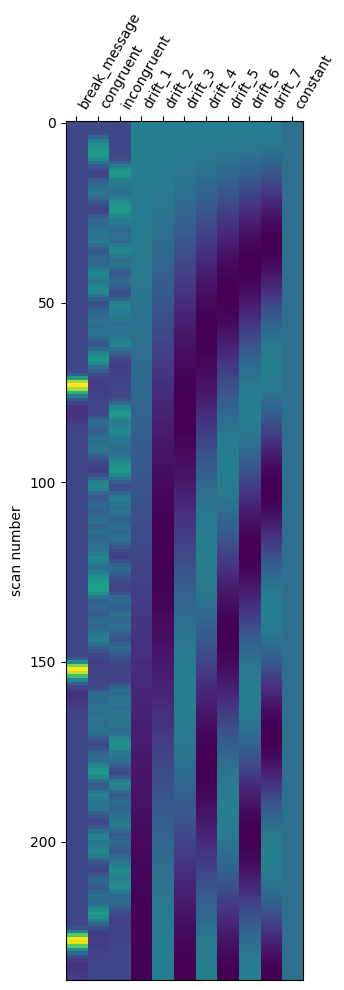

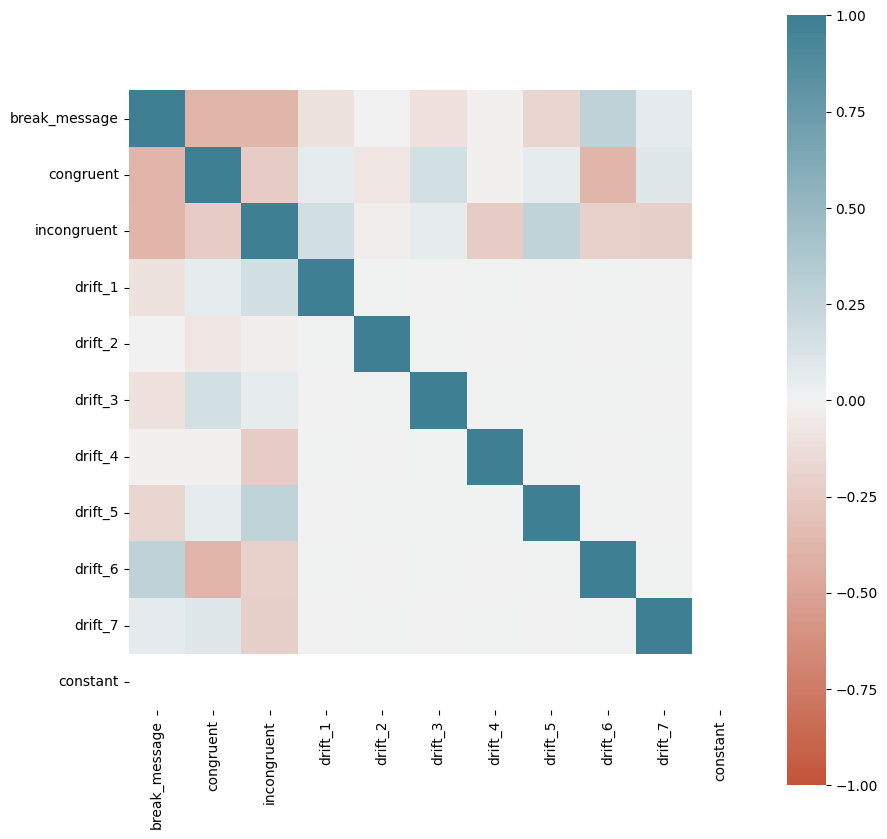

In [17]:
time_past_last_offset = 20
events_flanker = make_stop_flank_stroop_gng_timings(**events_inputs_flanker)
_, _, desmat_flanker = est_eff_and_vif(
    events_flanker,
    tr,
    total_time,
    contrasts_flanker,
    time_past_last_offset=time_past_last_offset,
    deriv=False,
)
name_swap = {'cond1': 'congruent', 'cond2': 'incongruent'}

desmat_flanker.columns = desmat_flanker.columns.to_series().replace(
    name_swap, regex=True
)

plot_design_matrix(desmat_flanker)
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    desmat_flanker.corr(),
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax,
)
plt.show()

In [18]:
nsim = 250
output_setting1_flanker, events_setting1_flanker = run_eff_sim(
    nsim,
    events_inputs_flanker,
    make_stop_flank_stroop_gng_timings,
    contrasts_flanker,
    avg_trial_repeats_info,
    tr,
    total_time,
    trials_psych_assess_map,
    avg_prob_given_last1,
    avg_prob_given_last2,
    name_swap=name_swap,
    time_past_last_offset=20,
    deriv=False,
)

In [19]:
# decrease the time_past_last_offset
output_setting2_flanker, events_setting2_flanker = run_eff_sim(
    nsim,
    events_inputs_flanker,
    make_stop_flank_stroop_gng_timings,
    contrasts_flanker,
    avg_trial_repeats_info,
    tr,
    total_time,
    trials_psych_assess_map,
    avg_prob_given_last1,
    avg_prob_given_last2,
    name_swap=name_swap,
    time_past_last_offset=10,
    deriv=False,
)

In [20]:
pd.set_option('display.width', 1000)

summary_names = (
    [f'eff_{name}' for name in contrasts_flanker.keys()]
    + [f'vif_{name}' for name in contrasts_flanker.keys()]
    + ['scan_length']
)

eff_vif_summaries_flanker = {}
eff_vif_summaries_flanker['setting1'] = np.round(
    output_setting1_flanker[summary_names].quantile(q=[0.05, 0.5, 0.95]), 2
)
eff_vif_summaries_flanker['10s past last offset'] = np.round(
    output_setting2_flanker[summary_names].quantile(q=[0.05, 0.5, 0.95]), 2
)

for key, val in eff_vif_summaries_flanker.items():
    print(f'Results for {key}')
    print(val)

Results for setting1
      eff_congruent  eff_incongruent  eff_incongruent-congruent  eff_task  vif_congruent  vif_incongruent  vif_incongruent-congruent  vif_task  scan_length
0.05           1.71             1.73                       2.35      2.13           1.97             2.02                       0.74      3.19       352.95
0.50           2.06             2.02                       3.04      2.44           2.43             2.42                       0.80      4.07       362.29
0.95           2.37             2.40                       3.75      2.85           2.90             2.93                       0.91      4.99       370.92
Results for 10s past last offset
      eff_congruent  eff_incongruent  eff_incongruent-congruent  eff_task  vif_congruent  vif_incongruent  vif_incongruent-congruent  vif_task  scan_length
0.05           1.58             1.58                       2.37      1.92           2.09             2.12                       0.71      3.44       342.85
0.50      

## Go/NoGo


In [21]:
events_inputs_gng = {
    'nc1': 162,
    'nc2': 27,
    'c1_dur': 1,
    'c2_dur': 1,
    'blank_dur': 0.5,
    'nbreaks': 2,
    'break_fix_pre_message_dur': 6,
    'break_message_dur': 4,
    'break_fix_post_message_dur': 6,
    'isi_exp_lam': 2,
    'isi_truncation': 4.5,
    'isi_shift': 0.5,
}


tr = 1.49
total_time = 10 * 60
contrasts_gng = {
    'go': 'cond1',
    'nogo': 'cond2',
    'nogo-go': 'cond2 - cond1',
    'task': '.5*cond1+.5*cond2',
}

In [22]:
trials_psych_assess_map = {'cond1': '1', 'cond2': '2'}

unpermuted_trials = np.concatenate(
    [
        np.repeat('1', events_inputs_gng['nc1'] / 3),
        np.repeat('2', events_inputs_gng['nc2'] / 3),
    ],
    axis=0,
)
avg_trial_repeats_info = calc_expected_run_num_by_chance(unpermuted_trials, nsims=5000)

for val in ['1', '2']:
    avg_trial_repeats_info[f'{val}_run_counts'] = (
        avg_trial_repeats_info[f'{val}_run_counts'] * 3
    )
print(avg_trial_repeats_info.loc[:25, :])

avg_prob_given_last1, avg_prob_given_last2 = calc_avg_prob_next_given_last1_and_last2(
    unpermuted_trials
)
print(avg_prob_given_last1)
print(avg_prob_given_last2)

    run_length  1_run_counts  2_run_counts
0          1.0        3.3348       20.0424
1          2.0        3.2388        2.7948
2          3.0        2.7450        0.2760
3          4.0        2.4762        0.0384
4          5.0        2.0814        0.0024
5          6.0        1.7658        0.0000
6          7.0        1.5564        0.0000
7          8.0        1.3056        0.0000
8          9.0        1.1226        0.0000
9         10.0        0.9654        0.0000
10        11.0        0.8436        0.0000
11        12.0        0.6834        0.0000
12        13.0        0.5604        0.0000
13        14.0        0.4722        0.0000
14        15.0        0.3834        0.0000
15        16.0        0.3366        0.0000
16        17.0        0.2748        0.0000
17        18.0        0.2244        0.0000
18        19.0        0.1860        0.0000
19        20.0        0.1464        0.0000
20        21.0        0.1284        0.0000
21        22.0        0.1032        0.0000
22        2

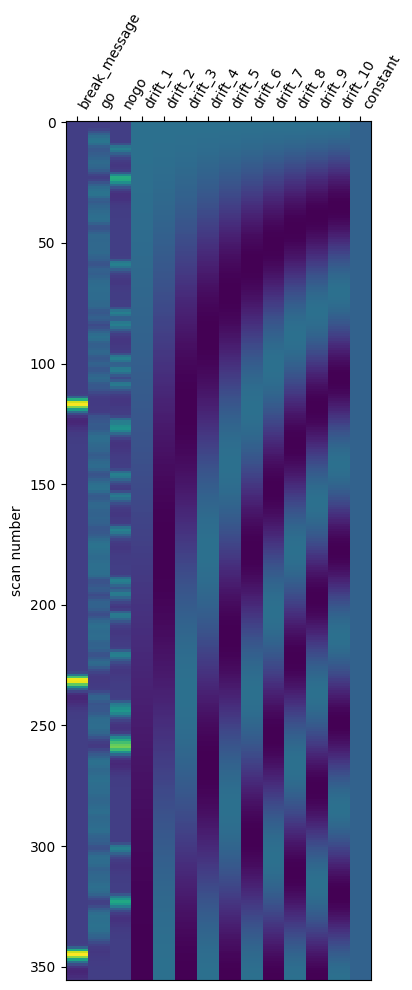

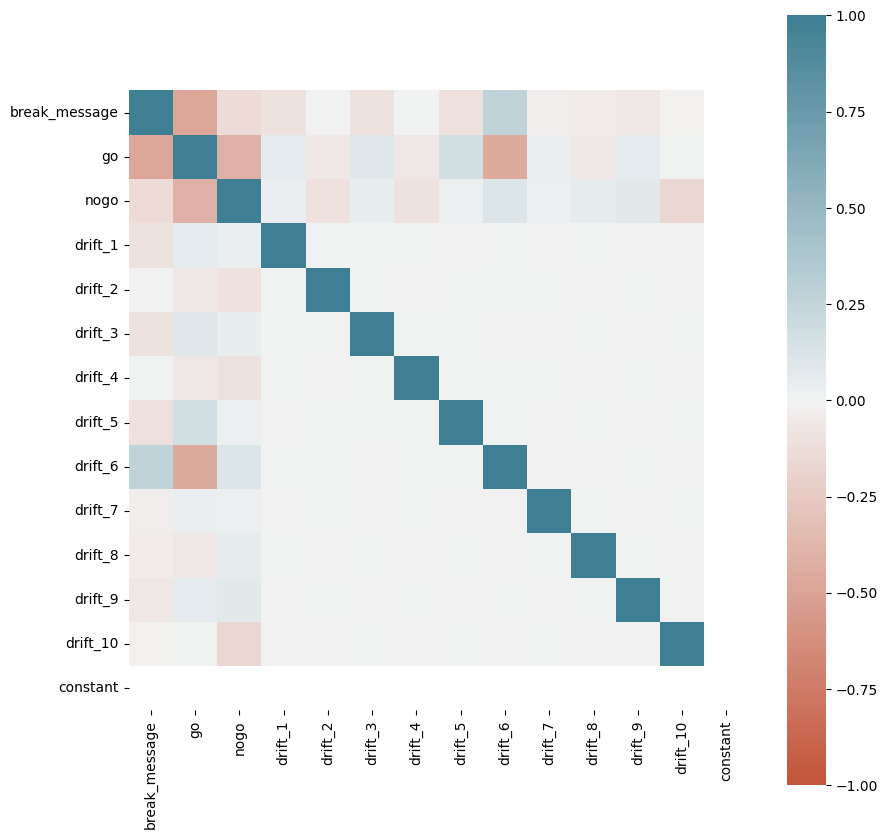

In [23]:
events_gng = make_stop_flank_stroop_gng_timings(**events_inputs_gng)
_, _, desmat_gng = est_eff_and_vif(
    events_gng, tr, total_time, contrasts_gng, deriv=False
)

name_swap = {'cond1': 'go', 'cond2': 'nogo'}

desmat_gng.columns = desmat_gng.columns.to_series().replace(name_swap, regex=True)

plot_design_matrix(desmat_gng)
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    desmat_gng.corr(),
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax,
)
plt.show()

In [24]:
nsim = 250
output_setting1_gng, events_setting1_gng = run_eff_sim(
    nsim,
    events_inputs_gng,
    make_stop_flank_stroop_gng_timings,
    contrasts_gng,
    avg_trial_repeats_info,
    tr,
    total_time,
    trials_psych_assess_map,
    avg_prob_given_last1,
    avg_prob_given_last2,
    time_past_last_offset=20,
    deriv=False,
)

In [25]:
nsim = 250
output_setting2_gng, events_setting2_gng = run_eff_sim(
    nsim,
    events_inputs_gng,
    make_stop_flank_stroop_gng_timings,
    contrasts_gng,
    avg_trial_repeats_info,
    tr,
    total_time,
    trials_psych_assess_map,
    avg_prob_given_last1,
    avg_prob_given_last2,
    time_past_last_offset=10,
    deriv=False,
)

In [26]:
summary_names = (
    [f'eff_{name}' for name in contrasts_gng.keys()]
    + [f'vif_{name}' for name in contrasts_gng.keys()]
    + ['scan_length']
)

eff_vif_summaries_gng = {}
eff_vif_summaries_gng['setting1 (20s time past last offset)'] = np.round(
    output_setting1_gng[summary_names].quantile(q=[0.05, 0.5, 0.95]), 2
)
eff_vif_summaries_gng['time past last offset=10s'] = np.round(
    output_setting2_gng[summary_names].quantile(q=[0.05, 0.5, 0.95]), 2
)

for key, val in eff_vif_summaries_gng.items():
    print(f'Results for {key}')
    print(val)

Results for setting1 (20s time past last offset)
      eff_go  eff_nogo  eff_nogo-go  eff_task  vif_go  vif_nogo  vif_nogo-go  vif_task  scan_length
0.05    2.70      1.34         1.98      2.31    2.29      1.51         0.81      2.89       523.87
0.50    3.06      1.60         2.40      2.67    2.58      1.74         0.90      3.43       533.88
0.95    3.43      1.85         2.90      3.07    2.95      2.06         0.99      4.09       544.99
Results for time past last offset=10s
      eff_go  eff_nogo  eff_nogo-go  eff_task  vif_go  vif_nogo  vif_nogo-go  vif_task  scan_length
0.05    2.43      1.29         1.99      2.13    2.35      1.58         0.79      3.04       514.82
0.50    2.73      1.50         2.38      2.43    2.64      1.84         0.87      3.61       524.18
0.95    3.08      1.77         3.00      2.76    2.98      2.15         0.96      4.30       534.41
